In [1]:
import numpy as np
import pylab as plt
import pickle
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)
import h5py
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

plt.rcParams['font.size'] = 16

In [2]:
file_path = '/global/cfs/cdirs/m4236/cosmosweb/catalogs/hsc_jwst_matched_with_images_high_snr'
f = h5py.File(file_path, 'r')

list(f.keys())


['Confidence_level',
 'bulge_radius',
 'dec',
 'dec_specz',
 'disk_radius',
 'flux_err-cal_model_cfht-u',
 'flux_err-cal_model_f115w',
 'flux_err-cal_model_f150w',
 'flux_err-cal_model_f277w',
 'flux_err-cal_model_f444w',
 'flux_err-cal_model_hsc-g',
 'flux_err-cal_model_hsc-i',
 'flux_err-cal_model_hsc-r',
 'flux_err-cal_model_hsc-y',
 'flux_err-cal_model_hsc-z',
 'flux_model_cfht-u',
 'flux_model_f115w',
 'flux_model_f150w',
 'flux_model_f277w',
 'flux_model_f444w',
 'flux_model_hsc-g',
 'flux_model_hsc-i',
 'flux_model_hsc-r',
 'flux_model_hsc-y',
 'flux_model_hsc-z',
 'hsc_images',
 'id_specz_khostovan25',
 'jwst_images',
 'lephare_photozs',
 'lp_age',
 'lp_mass',
 'lp_sfr',
 'lp_ssfr',
 'lp_type',
 'lp_zpdf_l68',
 'lp_zpdf_u68',
 'mag_model_cfht-u',
 'mag_model_f115w',
 'mag_model_f150w',
 'mag_model_f277w',
 'mag_model_f444w',
 'mag_model_hsc-g',
 'mag_model_hsc-i',
 'mag_model_hsc-r',
 'mag_model_hsc-y',
 'mag_model_hsc-z',
 'photoz',
 'ra',
 'ra_specz',
 'specz']

In [5]:
# model_name = 'convnext'
# model_sizes = ['tiny', 'small', 'base', 'large']
# model_name = 'vit'
# model_sizes = ['base_16', 'large_16', 'huge_14']
# model_name = 'dino'
# model_sizes = ['s_14', 'b_14', 'l_14', 'g_14']
model_name = 'astroPT'
model_sizes = ['015M', '095M', '850M']
n = 5000
telescope = 'hsc'
upsampled = True
dir_out = '/pscratch/sd/a/ashodkh/platonic_universe/embeddings/'

embeddings = {}

for model_size in model_sizes:
    if upsampled:
        embeddings[model_size] = np.load(dir_out + f'embeddings_{telescope}_{n}_{model_name}_{model_size}_upsampled_images.npy')
    else:
        embeddings[model_size] = np.load(dir_out + f'embeddings_{telescope}_{n}_convnext{model_size}.npy')

if model_name == 'astroPT':
    with open(dir_out + f'features_{telescope}_{n}_{model_name}_{model_size}_upsampled_images.pkl', 'rb') as pickle_f:
        features = pickle.load(pickle_f)
        

In [4]:
def calculate_stats(y, y_pred, outlier_f=0.15):
    delta = (y_pred - y)
    bias = np.mean(delta)
    nmad = 1.4826*np.median(np.abs(delta - np.median(delta)))
    outlier_fraction = np.sum(np.abs(delta)/y>outlier_f)/len(y)
    return bias, nmad, outlier_fraction

def calculate_stats_redshift(y, y_pred, outlier_f=0.15):
    delta = (y_pred - y)/(1+y)
    bias = np.mean(delta)
    nmad = 1.4826*np.median(np.abs(delta - np.median(delta)))
    outlier_fraction = np.sum(np.abs(delta)>outlier_f)/len(y)
    return bias, nmad, outlier_fraction
    

In [6]:
params = ['mag_model_hsc-g', 'lp_mass', 'lp_ssfr', 'lephare_photozs']

r2 = {}
bias = {}
nmad = {}
outlier_f = {}

seed = 42
for model_size in model_sizes:
    r2[model_size] = {}
    bias[model_size] = {}
    nmad[model_size] = {}
    outlier_f[model_size] = {}
    embeddings_train, embeddings_test = train_test_split(embeddings[model_size], test_size=int(1000), random_state=seed)
    #scaler_x = StandardScaler()
    #embeddings_train = scaler_x.fit_transform(embeddings_train)
    #embeddings_test = scaler_x.transform(embeddings_test)
    for param in params:
        if model_name == 'astroPT':
            param_arr = features[param]
        else:
            param_arr = f[param][:n]
        param_arr_train, param_arr_test = train_test_split(param_arr, test_size=int(1000), random_state=seed)
        scaler_y = StandardScaler()
        #param_arr_train = scaler_y.fit_transform(param_arr_train.reshape(-1,1))
        #param_arr_test = scaler_y.transform(param_arr_test.reshape(-1,1))
        regressor = KNeighborsRegressor(n_neighbors=5)
        param_quantiles = np.quantile(param_arr_train, q=(0.01,0.99))
        param_arr_train = param_arr_train.clip(param_quantiles[0], param_quantiles[1])
        param_arr_test = param_arr_test.clip(param_quantiles[0], param_quantiles[1])
        regressor.fit(embeddings_train, param_arr_train)
        test_preds = regressor.predict(embeddings_test).clip(param_quantiles[0], param_quantiles[1])
        r2[model_size][param] = r2_score(param_arr_test, test_preds)
        if param == 'lephare_photozs':
            bias[model_size][param], nmad[model_size][param], outlier_f[model_size][param] = \
            calculate_stats_redshift(param_arr_test, test_preds)
        else:
            bias[model_size][param], nmad[model_size][param], outlier_f[model_size][param] = \
            calculate_stats(param_arr_test, test_preds)
            
        

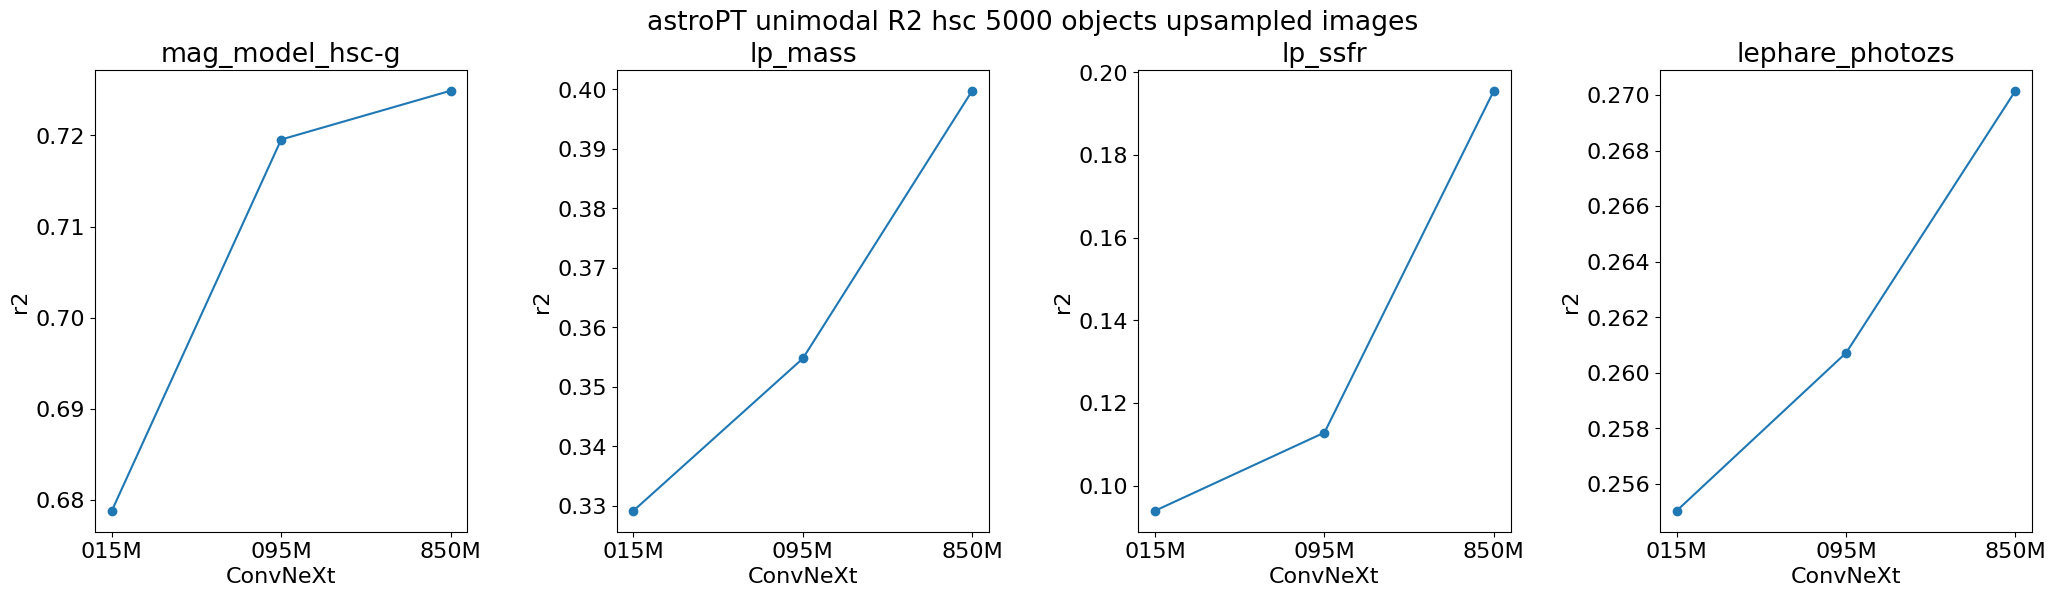

In [7]:
metrics = [r2]#, bias, nmad, outlier_f]
metric_names = ['r2']#, 'bias', 'nmad', 'outlier_f']

for k in range(len(metrics)):
    fig, ax = plt.subplots(ncols=len(params), figsize=(25,6))
    fig.subplots_adjust(wspace=0.4)
    
    for j, param in enumerate(params):
        ax[j].plot(np.arange(len(model_sizes)), [metrics[k][model_size][param] for model_size in model_sizes], 'o-', label=param)
        ax[j].set_title(param)
        ax[j].set_xlabel('ConvNeXt')
        ax[j].set_ylabel(metric_names[k])
        ax[j].set_xticks(np.arange(len(model_sizes)))
        ax[j].set_xticklabels(model_sizes)
    
    if upsampled:
        fig.suptitle(f'{model_name} unimodal R2 {telescope} {n} objects upsampled images')
        plt.savefig(f'{model_name}_unimodal_R2_{telescope}_{n}_upsampled_images.png', bbox_inches='tight')
    else:
        fig.suptitle(f'{model_name} unimodal R2 {telescope} {n} objects')
        #plt.savefig(f'convnext_unimodal_R2_{telescope}_{n}.png', bbox_inches='tight')
    

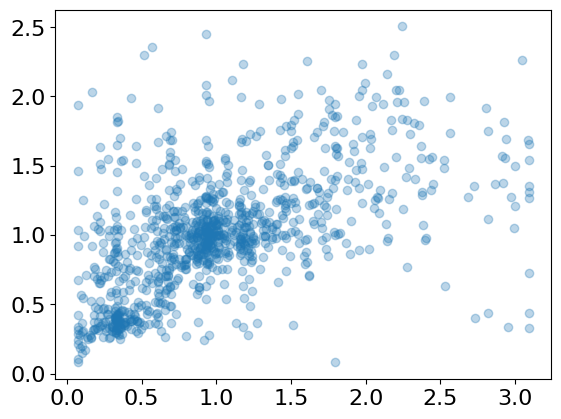

In [8]:
fig, ax = plt.subplots()

ax.scatter(param_arr_test.squeeze(), test_preds.squeeze(), alpha=0.3);

#ax.set_xlim(0,4)
#ax.set_ylim(0,4)

In [36]:
param_quantiles

array([0.068901  , 3.08998302])